# TME8 : Explication d'exceptions

Borchani Sofia 21212080   
Bouchouchi Nour 28600211

## Génération de donnéees

In [1]:
#!pip install pyod

In [2]:
#!pip install shap

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from utils_tme8 import *

In [4]:
np.random.seed(42)

In [5]:
# Définir le nombre de points pour chaque cluster
num_points_cluster1 = 100
num_points_cluster2 = 100
num_points_cluster3 = 100
num_points_cluster4 = 30
num_points_cluster5 = 30

# Générer des données pour chaque cluster
cluster1_x = np.random.normal(10, 2, num_points_cluster1)
cluster1_y = np.random.normal(20, 0.4, num_points_cluster1)

cluster2_x = np.random.normal(15, 0.5, num_points_cluster2)
cluster2_y = np.random.normal(10, 2, num_points_cluster2)

cluster3_x = np.random.normal(2, 4, num_points_cluster3)
cluster3_y = np.random.normal(15, 0.4, num_points_cluster3)

cluster4_x = np.random.normal(25, 0.6, num_points_cluster4)
cluster4_y = np.random.normal(16.5, 0.4, num_points_cluster4)

cluster5_x = np.random.normal(25, 0.6, num_points_cluster5)
cluster5_y = np.random.normal(12.5, 0.4, num_points_cluster5)

exception1_x = np.random.normal(25, 0, 1)
exception1_y = np.random.normal(14.5, 0, 1)


# Génération d'exceptions 
exception2_x = np.random.normal(-5, 0, 1)
exception2_y = np.random.normal(6.5, 0, 1)

exception3_x = np.random.normal(5, 0, 1)
exception3_y = np.random.normal(8, 0, 1)


# Concaténer les données de tous les clusters
x_normal = np.concatenate([cluster1_x, cluster2_x, cluster3_x, cluster4_x, cluster5_x])
y_normal = np.concatenate([cluster1_y, cluster2_y, cluster3_y, cluster4_y, cluster5_y])
x_exception = np.concatenate([exception1_x, exception2_x, exception3_x])
y_exception = np.concatenate([exception1_y, exception2_y, exception3_y])



On génère cinq clusters distincts avec des points répartis selon des distributions normales.  
  
On génère également trois execptions fixées manuellement que l'on affichera en rouge :   
      - A(25, 14.5)  
      - B(-5, 6.5)   
      - C(5, 8)
      

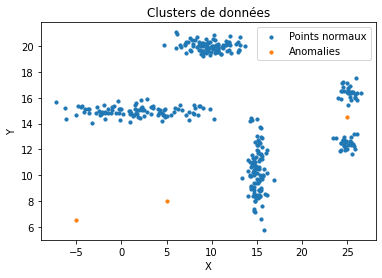

In [6]:
# Afficher les clusters
plt.scatter(x_normal, y_normal, s=10, label="Points normaux")
plt.scatter(x_exception, y_exception, s=10, label="Anomalies")
plt.title("Clusters de données")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

x = np.concatenate([x_normal, x_exception])
y = np.concatenate([y_normal, y_exception])

data = np.column_stack((x, y))

In [7]:
def affiche_frontiere2D(model, X_train):
    """    
    Affiche la frontière de décision d'un modèle
    model : modèle de détection d'anomalies
    X_train : les données d'apprentissage  
    """
    # Génération d'une grille
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Prédiction chaque point de la grille
    data_grid = np.c_[xx.ravel(), yy.ravel()]
    confidence = model.decision_function(data_grid)
    confidence = confidence.reshape(xx.shape)

    # Affichage du dégradé de couleurs
    plt.contourf(xx, yy, confidence, cmap='Blues', alpha=0.5)


In [8]:
def affichage(prediction, isolation, x, y):
    # Séparer les anomalies et les points normaux
    anomalies_x = x[prediction == -1]
    anomalies_y = y[prediction == -1]

    normal_x = x[prediction == 1]
    normal_y = y[prediction == 1]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axs[0].scatter(normal_x, normal_y, s=10, label='Points normaux')
    axs[0].scatter(anomalies_x, anomalies_y, s=50, color='r', marker='x', label='Anomalies')
    axs[0].set_title("Détection d'anomalies avec Isolation Forest")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()

    scatter = axs[1].scatter(normal_x, normal_y, s=10, label='Points normaux', cmap='cividis')
    scatter = axs[1].scatter(anomalies_x, anomalies_y, s=50, color='r', marker='x', label='Anomalies', cmap='cividis')
    axs[1].set_title("Détection d'anomalies avec Isolation Forest")
    affiche_frontiere2D(isolation, data)
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Y")
    axs[1].legend()
    #fig.colorbar(scatter, ax=axs[1], label='Confiance (Degré de non-anomalie)', cmap='cividis')
    plt.tight_layout()
    plt.show()


## Isolation forest

On utilise une forêt d'isolation qui isole les données normales en s'appuyant sur un ensemble d'arbres de décision, facilitant ainsi la détection des anomalies. 

In [9]:
# Modèle IsolationForest
isolation_forest = IsolationForest()  
isolation_forest.fit(data)

# Prédiction des anomalies
predictions_forest = isolation_forest.predict(data)

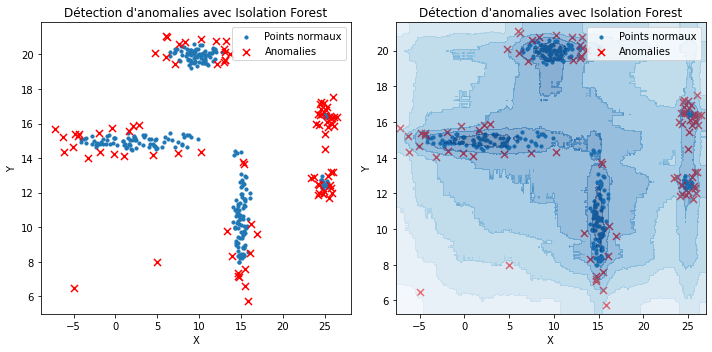

In [10]:
affichage(predictions_forest, isolation_forest, x, y)

### Etude du paramètre de contamination

On observe ici que de nombreux points peuvent être considérés comme des anomalies. Il peut donc être intéressant de se pencher sur le paramètre contamination. On étudie les exemples obtenus pour une contamination de 0.01, 0.03, 0.06, 0.07, 0.08, 0.1.

In [11]:
def etude_contamination(x, y, liste_contamination):

    fig, axs = plt.subplots(nrows=1, ncols=len(liste_contamination), figsize=(5*len(liste_contamination), 5))

    liste_anomalies_x = []
    liste_anomalies_y = []
    liste_scores = []
    for i in range(len(liste_contamination)): 
        # Modèle IsolationForest
        isolation_forest = IsolationForest(contamination=liste_contamination[i])  
        isolation_forest.fit(data)

        # Prédiction des anomalies
        prediction = isolation_forest.predict(data)
        anomalies_x = x[prediction == -1]
        anomalies_y = y[prediction == -1]

        normal_x = x[prediction == 1]
        normal_y = y[prediction == 1]


        axs[i].scatter(normal_x, normal_y, s=10, label='Points normaux')
        axs[i].scatter(anomalies_x, anomalies_y, s=50, color='r', marker='x', label='Anomalies')
        axs[i].set_title(f"contamination = {liste_contamination[i]}")
        axs[i].set_xlabel("X")
        axs[i].set_ylabel("Y")
        axs[i].legend()

        liste_anomalies_x.append(anomalies_x)
        liste_anomalies_y.append(anomalies_y)
        scores = isolation_forest.score_samples(np.column_stack((x, y)))
        liste_scores.append(scores)

    plt.tight_layout()
    plt.show()
    return liste_anomalies_x, liste_anomalies_y, liste_scores

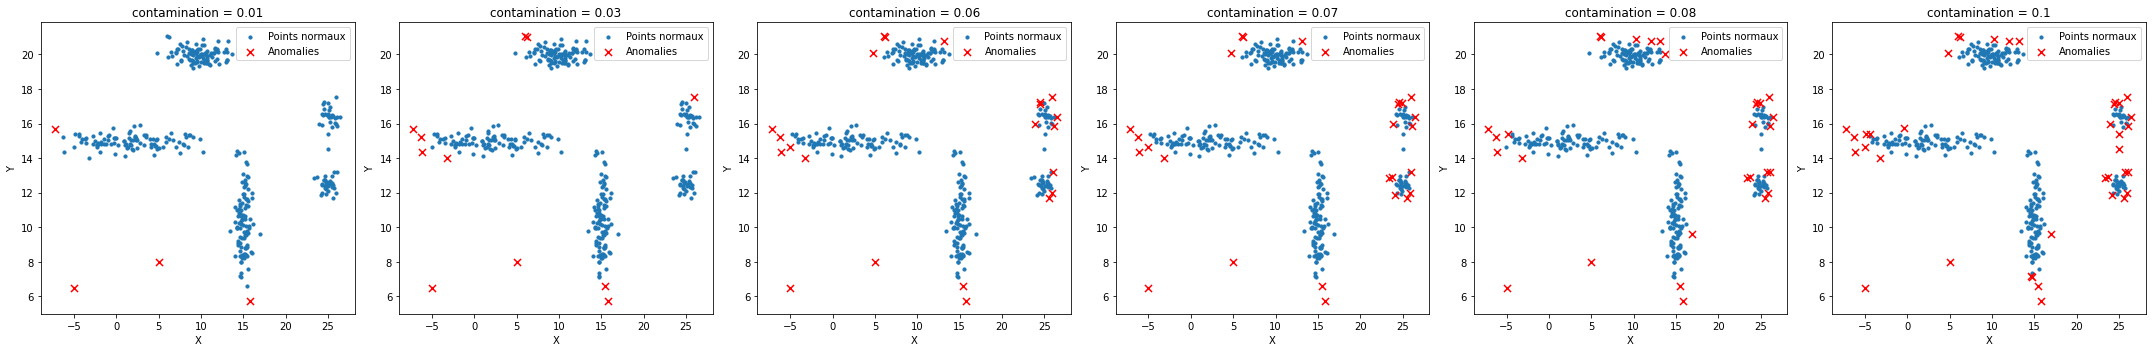

In [12]:
liste_contamination = [0.01, 0.03, 0.06, 0.07, 0.08, 0.1]
liste_anomalies_x, liste_anomalies_y, liste_scores = etude_contamination(x, y, liste_contamination)

### Etude d'un "faux outlier" (avec contamination = 0.01)

Ici on observe que certaines données prédites lorsque la contamination vaut 0.1 ne font pas partie des trois données que nous avions manuellement générées comme outlier. Par ailleurs, il faut attendre une contamination de 0.07 pour que le point A de coordonnées (25, 14.5) soit considéré comme un outlier. Il peut donc être intéressant de se demander pourquoi certains point étaient prédits comme des outliers alors que le point A ne l'est pas. 

On commence par afficher les coordonées des points prédits comme étant des outliers : 

In [13]:
anomalies_x_0_01 = liste_anomalies_x[0]
anomalies_y_0_01 = liste_anomalies_y[0]
for x_001,y_001 in zip(anomalies_x_0_01, anomalies_y_0_01) : 
    print(f"({x_001}, {y_001})")

D = (anomalies_x_0_01[1], anomalies_y_0_01[1])

(15.793008408072676, 5.752208551380386)
(-7.207684658942339, 15.670574924910113)
(-5.0, 6.5)
(5.0, 8.0)


On reconnait les points B(-5.0, 6.5) et C(5.0, 8.0) générés comme des anomalies. Néanmoins les points (15.793008408072676, 5.752208551380386) et (-7.207684658942339, 15.670574924910113) auraient dû être des points normaux.  
  
On va se pencher sur le point D(-7.207684658942339, 15.670574924910113) afin d'essayer de déterminer pourquoi il a été prédit comme étant un outlier. 

On commence par afficher les lignes de niveau dans le cas où la contamination vaut 0.01. 

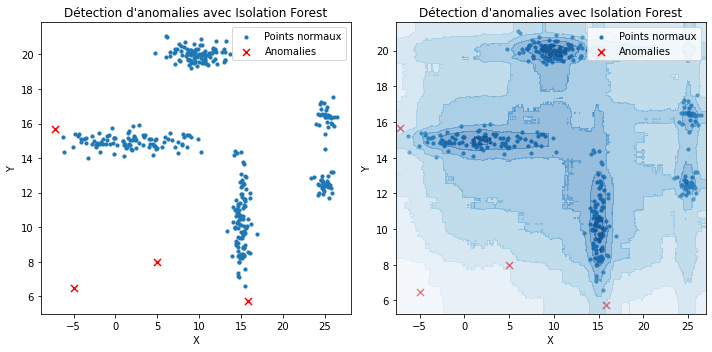

In [14]:
# Modèle IsolationForest
isolation_forest = IsolationForest(contamination=0.01)  
isolation_forest.fit(data)

# Prédiction des anomalies
predictions_forest = isolation_forest.predict(data)

affichage(predictions_forest, isolation_forest, x, y)

Une première observation qui peut être faite ici est le fait que le point D appartient au 5e niveau de frontière de décision alors que le point A appartient au 2nd niveau. 

#### Approche avec l'algorithme des growing spheres 

Nous allons chercher à générer un exemple contre-factuel à l'aide de l'algorithme des Growing Spheres dans le but d'expliquer la classification du point D comme étant un outlier. 

In [15]:
D = np.array(D)
e = GS(isolation_forest, D,0.5,50)


print("Point initial :", D)
print("e : ", e)
e_star = feature_selection(isolation_forest,D,e)
print("e* de ce point : ", e_star)

Point initial : [-7.20768466 15.67057492]
e :  [-7.20647971 15.32034818]
e* de ce point :  [-7.20768466 15.32034818]


L'exemple contre-factuel e* parcimonieux diffère de D de par son attribut y qui est plus fiable. C'est donc l'ordonnée de D qui permet d'expliquer sa classification en tant qu'outlier. On peut observer graphiquement les localisations de D et de e* ci-dessous. 

In [16]:
def affichage_contrefactuel(prediction, isolation, x, y, instance, contrefactuel):
    # Séparer les anomalies et les points normaux
    anomalies_x = x[prediction == -1]
    anomalies_y = y[prediction == -1]

    normal_x = x[prediction == 1]
    normal_y = y[prediction == 1]

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    axs[0].scatter(normal_x, normal_y, s=10, label='Points normaux')
    axs[0].scatter(anomalies_x, anomalies_y, s=30, color='r', marker='x', label='Anomalies')
    axs[0].set_title("Détection d'anomalies avec Isolation Forest")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()

    scatter = axs[1].scatter(normal_x, normal_y, s=10, label='Points normaux', cmap='cividis')
    scatter = axs[1].scatter(anomalies_x, anomalies_y, s=30, color='r', marker='x', label='Anomalies', cmap='cividis')
    axs[1].set_title("Détection d'anomalies avec Isolation Forest")
    affiche_frontiere2D(isolation, data)
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Y")

    # Tracer l'instance et le contrefactuel au premier plan
    axs[0].scatter(instance[0], instance[1], s=70, color='green', marker='o', label='Instance')
    axs[1].scatter(instance[0], instance[1], s=40, color='green', marker='o', label='Instance')
    axs[1].scatter(contrefactuel[0], contrefactuel[1], s=40, color='orange', marker='o', label='Contrefactuel')


    axs[0].legend()
    axs[1].legend()
    plt.tight_layout()
    plt.show()


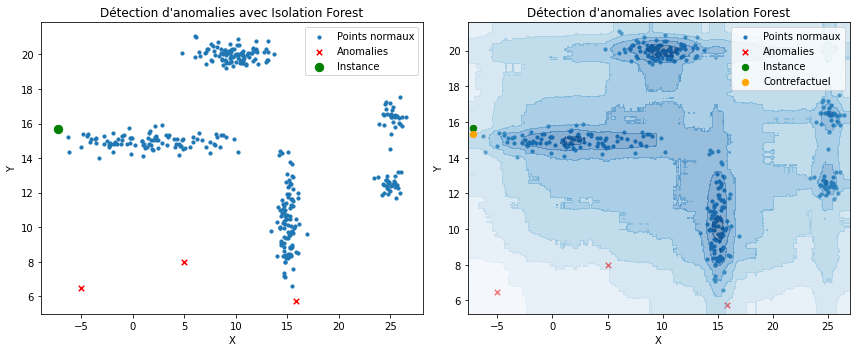

In [17]:
affichage_contrefactuel(predictions_forest, isolation_forest, x, y, D, e_star)

#### Approche par vecteurs d'importance

On s'intéresse désormais à savoir si certains attributs ont une importance plus élevée pour la prédiction d'outlier. On commence par regarder si dans l'ensemble des données un attribut a plus d'importance que l'autre.

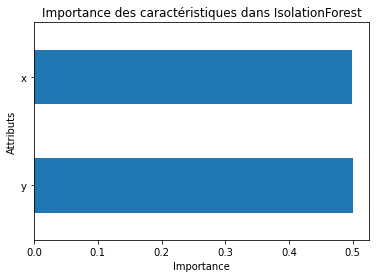

In [18]:
feature_names = ["x", "y"]

average_feature_importance = np.mean([tree.feature_importances_ for tree in isolation_forest.estimators_], axis=0)
feature_importance_series = pd.Series(average_feature_importance, index=feature_names)

sorted_feature_importance = feature_importance_series.nlargest()
sorted_feature_importance.plot(kind='barh')
plt.title('Importance des caractéristiques dans IsolationForest')
plt.xlabel('Importance')
plt.ylabel('Attributs')
plt.show()


Ici on observe que les deux attributs ont la même importance dans la prédiction. Cela s'explique par le fait que certains clusters soient horizontaux et d'autres verticaux il n'y a donc pas une dimension plus importante que l'autre.  
   
On veut maintenant chercher à expliquer le fait que le point D ai été prédit comme outlier alors que nous ne l'avions pas généré comme tel. On veut donc regarder si un attribut a eu plus d'impact pour cette prédiction. 

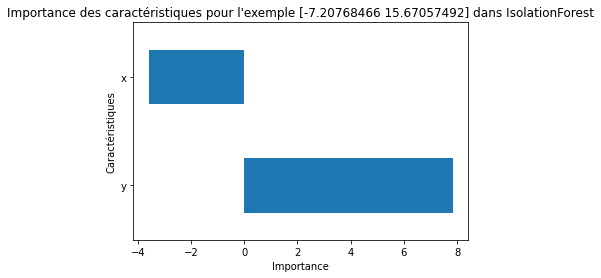

In [19]:
average_feature_importance = np.mean([tree.feature_importances_ for tree in isolation_forest.estimators_], axis=0)

feature_importance_series = pd.Series(average_feature_importance, index=feature_names)

sorted_feature_importance = feature_importance_series * D
sorted_feature_importance = sorted_feature_importance.nlargest()

sorted_feature_importance.plot(kind='barh')
plt.title(f'Importance des caractéristiques pour l\'exemple {D} dans IsolationForest')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()

On observe que la dimension y (axe des ordonnées) a beaucoup joué dans la prédiction en tant qu'outlier de façon positive tandis que la dimension x (axe des abscisse) a tendance a jouer négativement sur la prédiction de D comme étant un outlier. En observant la localisation de D on se rend compte que cela coincide avec sa position par rapport au cluster le plus proche. Ce cluster est horizontal, il s'étale donc le long de l'axe des abscisse (les points de ce cluster prennent des valeurs d'abscisse assez disparates allant d'environ -3 a 12), mais il a des valeurs relativement restreintes le long de l'axe des ordonnées (autour de 13). Par conséquent, la valeur de l'ordonnée du point D aura une grande influence et sera très discriminante pour déterminer si ce point est un outlier ou non.   
  
On note que cela correspond à ce que l'on avait noté précédemment avec l'algorithme des Growing Spheres : l'explication porte sur l'ordonnée du point D. 

### Etude d'un outlier non prédit comme tel (avec contamination = 0.01)

Désormais, nous allons nous intéresser a un point que nous avions généré comme un outlier mais qui n'a pas été considéré comme tel avec une contamination de 0.01 à savoir le point A(25;14.5). Nous allons chercher à savoir pourquoi ce point n'a pas été considéré comme outlier. 

In [20]:
A = np.array((x_exception[0], y_exception[0]))
e = GS(isolation_forest, A,0.5,50)


print("Point initial :", A)
print("e : ", e)
e_star = feature_selection(isolation_forest,A,e)
print("e* de ce point : ", e_star)

Point initial : [25.  14.5]
e :  [26.26807623 17.71593015]
e* de ce point :  [26.26807623 17.71593015]


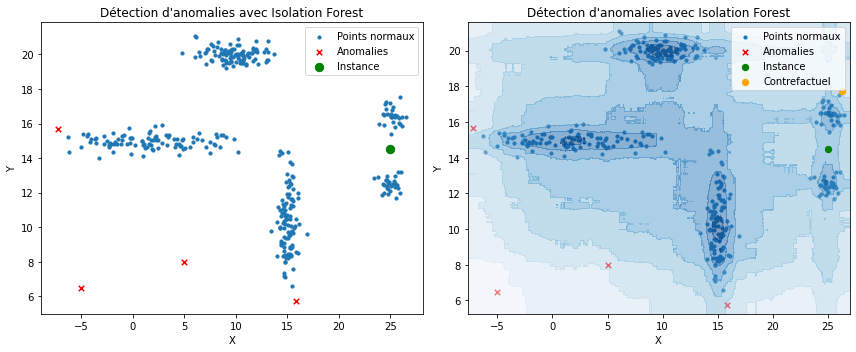

In [21]:
affichage_contrefactuel(predictions_forest, isolation_forest, x, y, A, e_star)

Ici, on observe que l'exemple contrefactuel de A varie non seulement sur l'axe des ordonnées mais aussi sur l'axe des abscisses. En effet, ce que nous avions généré comme deux clusters distincts semble être ici regroupé en un cluster (pour contamination=0.01).

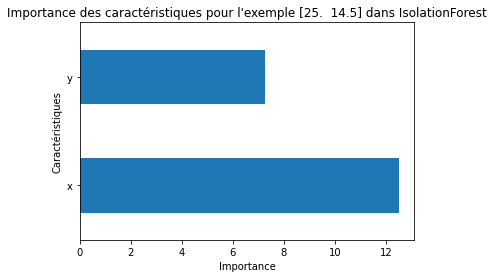

In [22]:
average_feature_importance = np.mean([tree.feature_importances_ for tree in isolation_forest.estimators_], axis=0)

feature_importance_series = pd.Series(average_feature_importance, index=feature_names)

sorted_feature_importance = feature_importance_series * A
sorted_feature_importance = sorted_feature_importance.nlargest()

sorted_feature_importance.plot(kind='barh')
plt.title(f'Importance des caractéristiques pour l\'exemple {A} dans IsolationForest')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()

Cette fois, les deux coordonnées jouent de façon importante et positive dans l'explication de l'exemple A comme n'étant pas un outlier. Le rôle de l'abscisse est légèrement plus improtant. Cela pourrait s'expliquer par le fait qu'une fois réunis, nos deux clusters forment une sorte de cluster vertical. Le point A se retrouve donc au milieu du cluster.

### Explication moins naïve

In [23]:
#!git clone https://github.com/mattiacarletti/DIFFI.git

In [24]:
import sys
sys.path.append("./DIFFI/")
from DIFFI.utils import *
import DIFFI.interpretability_module  as interp

In [25]:
data_exception = np.column_stack((x_exception, y_exception))

In [26]:
isolation_forest.max_samples =64

In [35]:
y_te_pred = np.array(isolation_forest.decision_function(data_exception) < 0).astype('int')
print('Detected anomalies: {} out of {}'.format(int(sum(y_te_pred)), len(x_exception)))
print("Les points prédits comme outliers parmi nos outliers sont : \n", data_exception[np.where(y_te_pred == 1)])

Detected anomalies: 2 out of 3
Les points prédits comme outliers parmi nos outliers sont : 
 [[-5.   6.5]
 [ 5.   8. ]]


Average computational time Local-DIFFI: 0.018


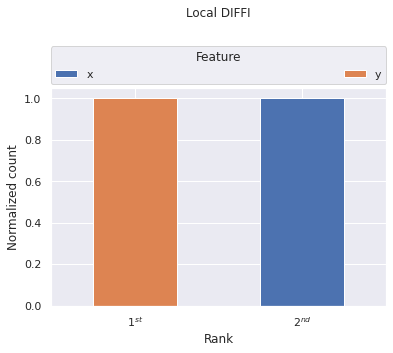

In [31]:
# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(isolation_forest data_exceptionn[np.where(y_te_pred == 1)])
plot_ranking_glass(ord_idx_diffi_te, title = 'Local DIFFI')
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_te),3)))


Average computational time SHAP: 0.224


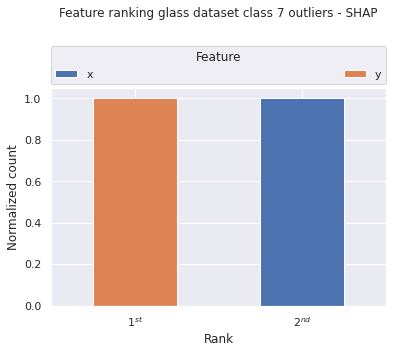

In [30]:
# SHAP
shap_te, ord_idx_shap_te, exec_time_shap_te = local_shap_batch(isolation_forest, data_exception[np.where(y_te_pred == 1)])
plot_ranking_glass(ord_idx_shap_te, title = 'Feature ranking glass dataset class 7 outliers - SHAP')
print('Average computational time SHAP: {}'.format(round(np.mean(exec_time_shap_te),3)))

## LocalOutlierFactor (LOF)

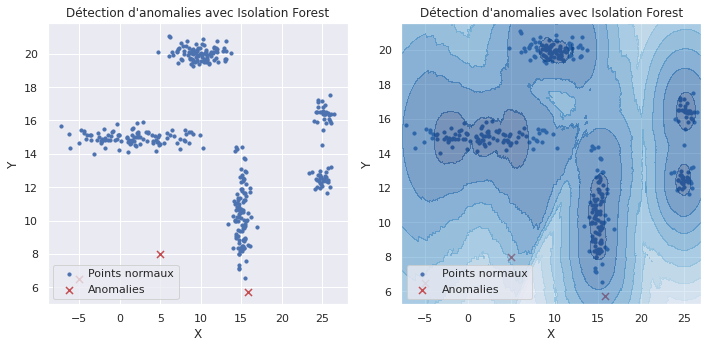

In [59]:
# Modèle LocalOutlierFactor
lof = LocalOutlierFactor(contamination=0.01, novelty=True)  # Set novelty to True
lof.fit(data)  # Fit on normal data

predictions_lof = lof.predict(data)

predictions_binary_lof = np.where(predictions_lof == 1, 0, 1)

affichage(predictions_lof, lof, x, y)

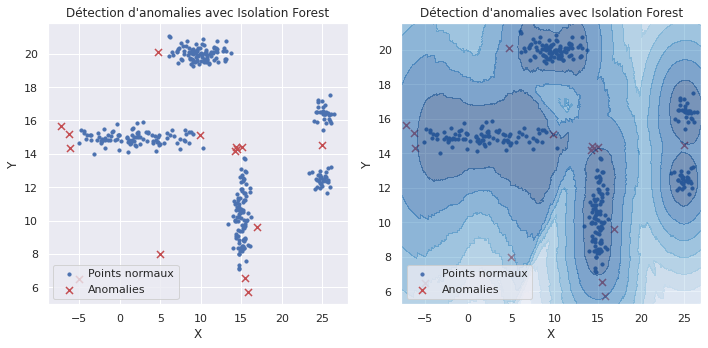

In [60]:
# Modèle LocalOutlierFactor
lof = LocalOutlierFactor(contamination=0.05, novelty=True)  # Set novelty to True
lof.fit(data)  # Fit on normal data

predictions_lof = lof.predict(data)

predictions_binary_lof = np.where(predictions_lof == 1, 0, 1)

affichage(predictions_lof, lof, x, y)

Point initial : [-7.20768466 15.67057492]
e :  [-5.73565377 15.53232447]
e* de ce point :  [-5.73565377 15.53232447]


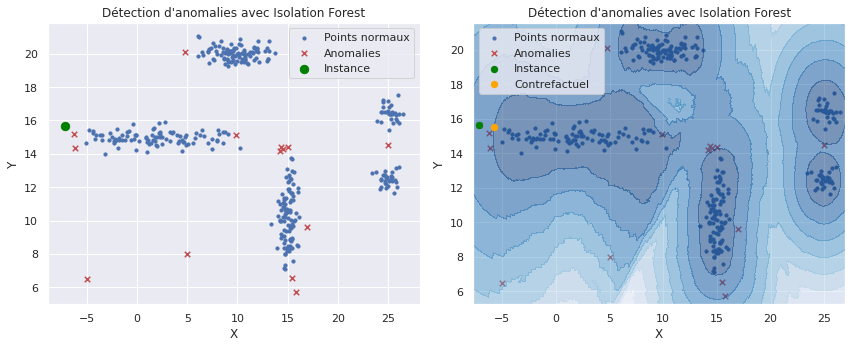

In [68]:
e = GS(lof, D,0.5,50)
print("Point initial :", D)
print("e : ", e)
e_star = feature_selection(lof,D,e)
print("e* de ce point : ", e_star)
affichage_contrefactuel(predictions_lof, lof, x, y, D, e_star)

## OneClassSVM

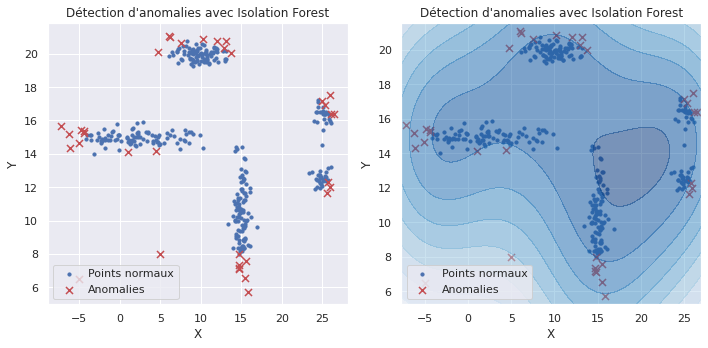

In [48]:
# Modèle OneClassSVM
ocs = OneClassSVM( nu=0.1) 
ocs.fit(data)

predictions_ocs = ocs.predict(data)

predictions_binary_ocs = np.where(predictions_ocs == 1, 0, 1)

affichage(predictions_ocs, ocs, x, y)

Point initial : [-7.20768466 15.67057492]
e :  [-4.02018262 15.19730594]
e* de ce point :  [-4.02018262 15.19730594]


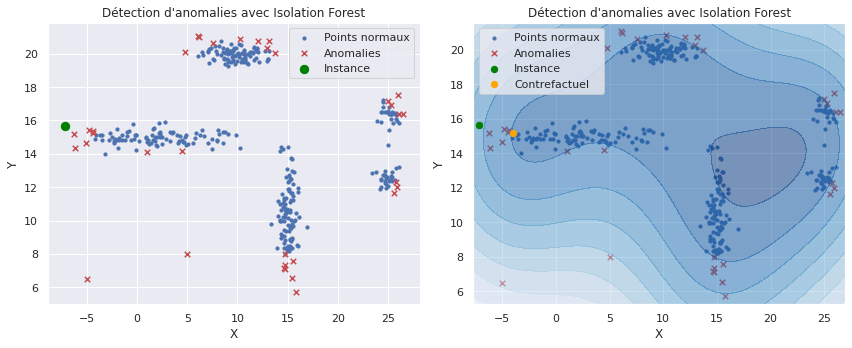

In [69]:
print("Point initial :", D)
e = GS(ocs, D,0.5,50)
print("e : ", e)
e_star = feature_selection(ocs,D,e)
print("e* de ce point : ", e_star)
affichage_contrefactuel(predictions_ocs, ocs, x, y, D, e_star)